<h1><center>Space missions data understanding, visualization and analysis</center></h1>

<center><img src="https://specials-images.forbesimg.com/imageserve/5ec807d92ce8db0007986fb2/960x0.jpg?fit=scale"></center>

## Hello everyone!

### In this kernel I am going to present basic EDA with interactive charts. Also we will see some interesting insights and prepare basic model for time series forecating. Let's do it!!!

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:Black; border:0' role="tab" aria-controls="home"><center>Quick navigation</center></h3>

* [1. General dataset overview](#1)
* [2. Geo analysis](#2)
* [3. Other imnteresting questions](#3)
* [4. Predict dynamics for CASC](#4)
* [5. USA vs USSR analysis](#5)
* [6. Best every year](#6)
* [7. Time series decomposition](#7)

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from iso3166 import countries
from statsmodels.tsa.arima_model import ARIMA
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import OrderedDict
from statsmodels.tsa.seasonal import seasonal_decompose

<a id="1"></a>
<h2 style='background:black; border:0; color:white'><center>1. General dataset overview<center><h2>

In [2]:
df = pd.read_csv('/kaggle/input/all-space-missions-from-1957/Space_Corrected.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


In [3]:
df.columns = ['Unnamed: 0', 'Unnamed: 0.1', 'Company Name', 'Location', 'Datum', 'Detail', 'Status Rocket', 'Rocket', 'Status Mission']
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

Let's see percent of NaNs for every column.

In [4]:
missed = pd.DataFrame()
missed['column'] = df.columns
percent = []
for col in df.columns:
    percent.append(round(100* df[col].isnull().sum() / len(df), 2))
missed['percent'] = percent
missed = missed.sort_values('percent')
missed = missed[missed['percent']>0]

fig = px.bar(
    missed, 
    x='percent', 
    y="column", 
    orientation='h', 
    title='Missed values percent for every column (percent > 0)', 
    width=600,
    height=200 
)

fig.show()

From this short chart we can see that we have only 1 column that contains missed values. It is `Rocket` column with about 80% of missed values.

Now let's see how many launches made every company presented in this dataset.

In [5]:
ds = df['Company Name'].value_counts().reset_index()
ds.columns = ['company', 'number of starts']
ds = ds.sort_values(['number of starts'])

fig = px.bar(
    ds, 
    x='number of starts', 
    y="company", 
    orientation='h', 
    title='Number of launches by every company', 
    width=800,
    height=1000 
)

fig.show()

What about rocket's status?

In [6]:
ds = df['Status Rocket'].value_counts().reset_index()
ds.columns = ['status', 'count']

fig = px.pie(
    ds, 
    values='count', 
    names="status", 
    title='Rocket status', 
    width=500, 
    height=500
)

fig.show()

Now we will check status distribution for all missions.

In [7]:
ds = df['Status Mission'].value_counts().reset_index()
ds.columns = ['mission_status', 'count']

fig = px.bar(
    ds, 
    x='mission_status', 
    y="count", 
    orientation='v', 
    title='Mission Status distribution', 
    width=500,
    height=500
)

fig.show()

And as last part of this section, lets see Value distribution for Rockets. A lot of them have missed values so lets set `0` for this samples.

In [8]:
df['Rocket'] = df['Rocket'].fillna(0.0).str.replace(',', '')
df['Rocket'] = df['Rocket'].astype(np.float64).fillna(0.0)
df['Rocket'] = df['Rocket'] * 1000000

In [9]:
df.loc[df['Rocket']>4000000000, 'Rocket'] = 0.0

fig = px.histogram(
    df, 
    "Rocket", 
    nbins=50, 
    title='Rocket Value distribution', 
    width=700, 
    height=500
)

fig.show()

<a id="2"></a>
<h2 style='background:black; border:0; color:white'><center>2. Geo analysis<center><h2>

First we need to extract `country` feature and change some country names.

In [10]:
df['country'] = df['Location'].str.split(', ').str[-1]

countries_dict = {
    'Russia' : 'Russian Federation',
    'New Mexico' : 'USA',
    "Yellow Sea": 'China',
    "Shahrud Missile Test Site": "Iran",
    "Pacific Missile Range Facility": 'USA',
    "Barents Sea": 'Russian Federation',
    "Gran Canaria": 'USA'
}

df['country'] = df['country'].replace(countries_dict)

Let's see sunburst chart for countries.

In [11]:
sun = df.groupby(['country', 'Company Name', 'Status Mission'])['Datum'].count().reset_index()
sun.columns = ['country', 'company', 'status', 'count']

fig = px.sunburst(
    sun, 
    path=[
        'country', 
        'company', 
        'status'
    ], 
    values='count', 
    title='Sunburst chart for all countries',
    width=600,
    height=600
)

fig.show()

Now let's convert country name to Alpha3 format using iso3166 package.

In [12]:
country_dict = {}
for c in countries:
    country_dict[c.name] = c.alpha3
    
df['alpha3'] = df['country']
df = df.replace({"alpha3": country_dict})
df.loc[df['country'] == "North Korea", 'alpha3'] = "PRK"
df.loc[df['country'] == "South Korea", 'alpha3'] = "KOR"
df

,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission,country,alpha3
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50000000.0,Success,USA,USA
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29750000.0,Success,China,CHN
2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,0.0,Success,USA,USA
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65000000.0,Success,Kazakhstan,KAZ
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145000000.0,Success,USA,USA
...,...,...,...,...,...,...,...,...,...
4319,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA","Wed Feb 05, 1958 07:33 UTC",Vanguard | Vanguard TV3BU,StatusRetired,0.0,Failure,USA,USA
4320,AMBA,"LC-26A, Cape Canaveral AFS, Florida, USA","Sat Feb 01, 1958 03:48 UTC",Juno I | Explorer 1,StatusRetired,0.0,Success,USA,USA
4321,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA","Fri Dec 06, 1957 16:44 UTC",Vanguard | Vanguard TV3,StatusRetired,0.0,Failure,USA,USA
4322,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan","Sun Nov 03, 1957 02:30 UTC",Sputnik 8K71PS | Sputnik-2,StatusRetired,0.0,Success,Kazakhstan,KAZ


In [13]:
def plot_map(dataframe, target_column, title, width=800, height=600):
    mapdf = dataframe.groupby(['country', 'alpha3'])[target_column].count().reset_index()
    fig = px.choropleth(
        mapdf, 
        locations="alpha3", 
        hover_name="country", 
        color=target_column, 
        projection="natural earth", 
        width=width, 
        height=height, 
        title=title
    )
    fig.show()

How many launches every country has?

In [14]:
plot_map(df, 'Status Mission', 'Number of starts per country')

How many Failures evry country has?

In [15]:
fail_df = df[df['Status Mission'] == 'Failure']
plot_map(fail_df, 'Status Mission', 'Number of Fails per country')

<a id="3"></a>
<h2 style='background:black; border:0; color:white'><center>3. Other interesting questions<center><h2>

How much money companies spent for missions?

In [16]:
data = df.groupby(['Company Name'])['Rocket'].sum().reset_index()
data = data[data['Rocket'] > 0]
data.columns = ['company', 'money']

fig = px.bar(
    data, 
    x='company', 
    y="money", 
    orientation='v', 
    title='Total money spent on missions', 
    width=800,
    height=600
)

fig.show()

In [17]:
money = df.groupby(['Company Name'])['Rocket'].sum()
starts = df['Company Name'].value_counts().reset_index()
starts.columns = ['Company Name', 'count']

av_money_df = pd.merge(money, starts, on='Company Name')
av_money_df['avg'] = av_money_df['Rocket'] / av_money_df['count']
av_money_df = av_money_df[av_money_df['avg']>0]
av_money_df = av_money_df.reset_index()

fig = px.bar(
    av_money_df, 
    x='Company Name', 
    y="avg", 
    orientation='v', 
    title='Average money per one launch', 
    width=800,
    height=600
)

fig.show()

Let's create traditional features based on Date

In [18]:
df['date'] = pd.to_datetime(df['Datum'])
df['year'] = df['date'].apply(lambda datetime: datetime.year)
df['month'] = df['date'].apply(lambda datetime: datetime.month)
df['weekday'] = df['date'].apply(lambda datetime: datetime.weekday())

How many launches were every year?

In [19]:
ds = df['year'].value_counts().reset_index()
ds.columns = ['year', 'count']

fig = px.bar(
    ds, 
    x='year', 
    y="count", 
    orientation='v', 
    title='Missions number by year', 
    width=800
)

fig.show()

What is months distribution?

In [20]:
ds = df['month'].value_counts().reset_index()
ds.columns = ['month', 'count']

fig = px.bar(
    ds, 
    x='month',
    y="count", 
    orientation='v', 
    title='Missions number by month', 
    width=800
)

fig.show()

What is weekday distribution?

In [21]:
ds = df['weekday'].value_counts().reset_index()
ds.columns = ['weekday', 'count']

fig = px.bar(
    ds, 
    x='weekday', 
    y="count", 
    orientation='v',
    title='Missions number by weekday', 
    width=800
)

fig.show()

How many years ago every company did last Rocket start?

In [22]:
res = []
for group in df.groupby(['Company Name']):
    res.append(group[1][['Company Name', 'year']].head(1))
data = pd.concat(res)
data = data.sort_values('year')
data['year'] = 2020 - data['year']

fig = px.bar(
    data, 
    x="year", 
    y="Company Name", 
    orientation='h', 
    title='Years from last start',
    width=900,
    height=1000
)

fig.show()

What is the average price per launch for every year?

In [23]:
money = df[df['Rocket']>0]
money = money.groupby(['year'])['Rocket'].mean().reset_index()

fig = px.line(
    money, 
    x="year", 
    y="Rocket",
    title='Average money spent by year'
)

fig.show()

Which companies are most experienced (years)?

In [24]:
ds = df.groupby(['Company Name'])['year'].nunique().reset_index()
ds.columns = ['company', 'count']

fig = px.bar(
    ds, 
    x="company", 
    y="count", 
    title='Most experienced companies (years of launches)'
)

fig.show()

Dynamics for some companies

In [25]:
data = df.groupby(['Company Name', 'year'])['Status Mission'].count().reset_index()
data.columns = ['company', 'year', 'starts']
top5 = data.groupby(['company'])['starts'].sum().reset_index().sort_values('starts', ascending=False).head(5)['company'].tolist()

In [26]:
data = data[data['company'].isin(top5)]

fig = px.line(
    data, 
    x="year", 
    y="starts", 
    title='Dynamic of top 5 companies by number of starts', 
    color='company'
)

fig.show()

Number of starts for 2020

In [27]:
data = df.groupby(['Company Name', 'year'])['Status Mission'].count().reset_index()
data.columns = ['company', 'year', 'starts']
data = data[data['year']==2020]

In [28]:
fig = px.bar(
    data, 
    x="company", 
    y="starts", 
    title='Number of starts for 2020', 
    width=800
)

fig.show()

In [29]:
data = df[df['Status Mission']=='Failure']
data = data.groupby(['Company Name', 'year'])['Status Mission'].count().reset_index()
data.columns = ['company', 'year', 'starts']
data = data[data['year']==2020]

fig = px.bar(
    data, 
    x="company", 
    y="starts", 
    title='Failures in 2020', 
    width=600
)

fig.show()

<a id="4"></a>
<h2 style='background:black; border:0; color:white'><center>4. Predict dynamics for CASC<center><h2>

As we can see CASC company has the higher number of launches in 2020. So lets try to predict dynamics for next 5 years for this company using simple ARIMA model.

In [30]:
data = df[df['Company Name'] == 'CASC']
data = data.groupby(['year'])['Company Name'].count().reset_index()
data = data[data['year'] < 2020]
data.columns = ['year', 'launches']

fig = px.line(
    data, 
    x="year", 
    y="launches", 
    title='Launches per year for CASC'
)

fig.show()

In [31]:
model = ARIMA(data['launches'], order=(2,2,1))
model_fit = model.fit(disp=0)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D2.launches   No. Observations:                   44
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -125.457
Method:                       css-mle   S.D. of innovations              3.972
Date:                Sun, 18 Oct 2020   AIC                            260.913
Time:                        22:07:09   BIC                            269.834
Sample:                             2   HQIC                           264.222
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0781      0.052      1.505      0.132      -0.024       0.180
ar.L1.D2.launches    -0.3378      0.136     -2.477      0.013      -0.605      -0.071
ar.L2.D2.launches     0.4984      0.160      3.110      0.002       0.184       0.813
ma.L1.D2.launches    -1.0000      0.074    -13.547      0.000      -1.145      -0.855
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1176           +0.0000j            1.1176            0.5000
AR.2            1.7953           +0.0000j            1.7953            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

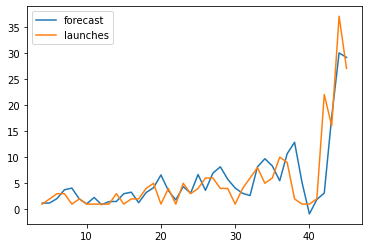

In [32]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [33]:
preds, _, _ = model_fit.forecast(6, alpha=0.05)

preds = preds.tolist()
preds = [int(item) for item in preds]
months = ['2020', '2021', '2022', '2023', '2024', '2025']

new_df = pd.DataFrame()
new_df['year'] = months
new_df['launches'] = preds
data = pd.concat([data, new_df])
fig = px.line(
    data, 
    x="year", 
    y="launches", 
    title='Launches per year prediction for CASC'
)

fig.show()

<a id="5"></a>
<h2 style='background:black; border:0; color:white'><center>5. USA vs USSR analysis<center><h2>

Space race was an important part in the cold war between USA and USSR. So lets check the results of it. 

In [34]:
cold = df[df['year'] <= 1991]
cold['country'].unique()
cold.loc[cold['country'] == 'Kazakhstan', 'country'] = 'USSR'
cold.loc[cold['country'] == 'Russian Federation', 'country'] = 'USSR'
cold = cold[(cold['country'] == 'USSR') | (cold['country'] == 'USA')]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Total number of launches

In [35]:
ds = cold['country'].value_counts().reset_index()
ds.columns = ['contry', 'count']
fig = px.pie(
    ds, 
    names='contry', 
    values="count", 
    title='Number of launches', 
    width=500
)

fig.show()

Launches year by year

In [36]:
ds = cold.groupby(['year', 'country'])['alpha3'].count().reset_index()
ds.columns = ['year', 'country', 'launches']
fig = px.bar(
    ds, 
    x="year", 
    y="launches", 
    color='country', 
    title='USA vs USSR: launches year by year',
    width=800
)

fig.show()

Number of companies year by year

In [37]:
ds = cold.groupby(['year', 'country'])['Company Name'].nunique().reset_index()
ds.columns = ['year', 'country', 'companies']

fig = px.bar(
    ds, 
    x="year", 
    y="companies", 
    color='country', 
    title='USA vs USSR: number of companies year by year',
    width=800
)

fig.show()

Number of failures year by year

In [38]:
ds = cold[cold['Status Mission'] == 'Failure']
ds = ds.groupby(['year', 'country'])['alpha3'].count().reset_index()
ds.columns = ['year', 'country', 'failures']

fig = px.bar(
    ds, 
    x="year", 
    y="failures", 
    color='country', 
    title='USA vs USSR: failures year by year', 
    width=800
)

fig.show()

<a id="6"></a>
<h2 style='background:black; border:0; color:white'><center>6. Best every year<center><h2>

Let's see witch countries and companies were the best for every year.

In [39]:
ds = df.groupby(['year', 'country'])['Status Mission'].count().reset_index().sort_values(['year', 'Status Mission'], ascending=False)
ds = pd.concat([group[1].head(1) for group in ds.groupby(['year'])])
ds.columns = ['year', 'country', 'launches']

fig = px.bar(
    ds, 
    x="year", 
    y="launches", 
    color='country', 
    title='Leaders by launches for every year (countries)'
)

fig.show()

In [40]:
ds = df[df['Status Mission']=='Success']
ds = ds.groupby(['year', 'country'])['Status Mission'].count().reset_index().sort_values(['year', 'Status Mission'], ascending=False)
ds = pd.concat([group[1].head(1) for group in ds.groupby(['year'])])
ds.columns = ['year', 'country', 'launches']

fig = px.bar(
    ds, 
    x="year", 
    y="launches", 
    color='country', 
    title='Leaders by success launches for every year (countries)'
)

fig.show()

In [41]:
ds = df.groupby(['year', 'Company Name'])['Status Mission'].count().reset_index().sort_values(['year', 'Status Mission'], ascending=False)
ds = pd.concat([group[1].head(1) for group in ds.groupby(['year'])])
ds.columns = ['year', 'company', 'launches']

fig = px.bar(
    ds, 
    x="year", 
    y="launches", 
    color='company', 
    title='Leaders by launches for every year (companies)'
)

fig.show()

In [42]:
ds = df[df['Status Mission']=='Success']
ds = ds.groupby(['year', 'Company Name'])['Status Mission'].count().reset_index().sort_values(['year', 'Status Mission'], ascending=False)
ds = pd.concat([group[1].head(1) for group in ds.groupby(['year'])])
ds.columns = ['year', 'company', 'launches']

fig = px.bar(
    ds, 
    x="year", 
    y="launches", 
    color='company', 
    title='Leaders by success launches for every year (companies)'
)

fig.show()

<a id="7"></a>
<h2 style='background:black; border:0; color:white'><center>7. Time series decomposition<center><h2>

In [43]:
df['month_year'] = df['year'].astype(str) + '-' + df['month'].astype(str)
df['month_year'] = pd.to_datetime(df['month_year']).dt.to_period('M')
ds = df.groupby(['month_year'])['alpha3'].count().reset_index()
ds.columns = ['month_year', 'count']
ds['month_year'] = ds['month_year'].astype(str)

fig = px.line(
    ds, 
    x='month_year', 
    y='count', 
    orientation='v', 
    title='Launches by months' 
)

fig.show()

December 1971 is most active month for Launch attempts.

Let's do decomposition of time series of number of launches for every month.

In [44]:
dates = ['1957-10-01', '2020-08-02']
start, end = [datetime.strptime(_, "%Y-%m-%d") for _ in dates]
dd = pd.DataFrame(list(OrderedDict(((start + timedelta(_)).strftime(r"%Y-%m"), None) for _ in range((end - start).days)).keys()), columns=['date'])
dd['date'] = pd.to_datetime(dd['date'])
ds['month_year'] = pd.to_datetime(ds['month_year'])
res = pd.merge(ds, dd, how='outer', left_on='month_year', right_on='date')
res = res.sort_values('date')[['date', 'count']]
res = res.fillna(0)
res = res.set_index('date')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



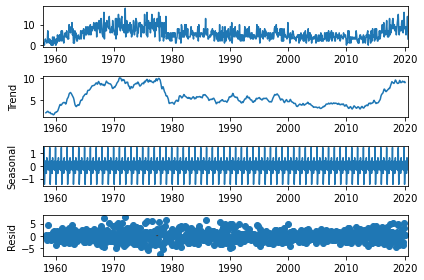

In [45]:
result = seasonal_decompose(res, model='additive', freq=12)
fig = result.plot()
matplotlib.rcParams['figure.figsize'] = [20, 15]
plt.show()

Let's drop noise from time series

In [46]:
ts = (result.trend + result.seasonal).reset_index()
ts.columns = ['date', 'count']
ts['origin'] = 'cleaned'
dres = res.reset_index()
dres['origin'] = 'original'
data = pd.concat([dres, ts])

In [47]:
fig = px.line(
    data, 
    x='date', 
    y='count', 
    color='origin', 
    orientation='v', 
    title='Original and cleaned time series', 
    width=800
)

fig.show()

Simple modeling

In [48]:
model = ARIMA(ds['count'], order=(10,1,2))
model_fit = model.fit()

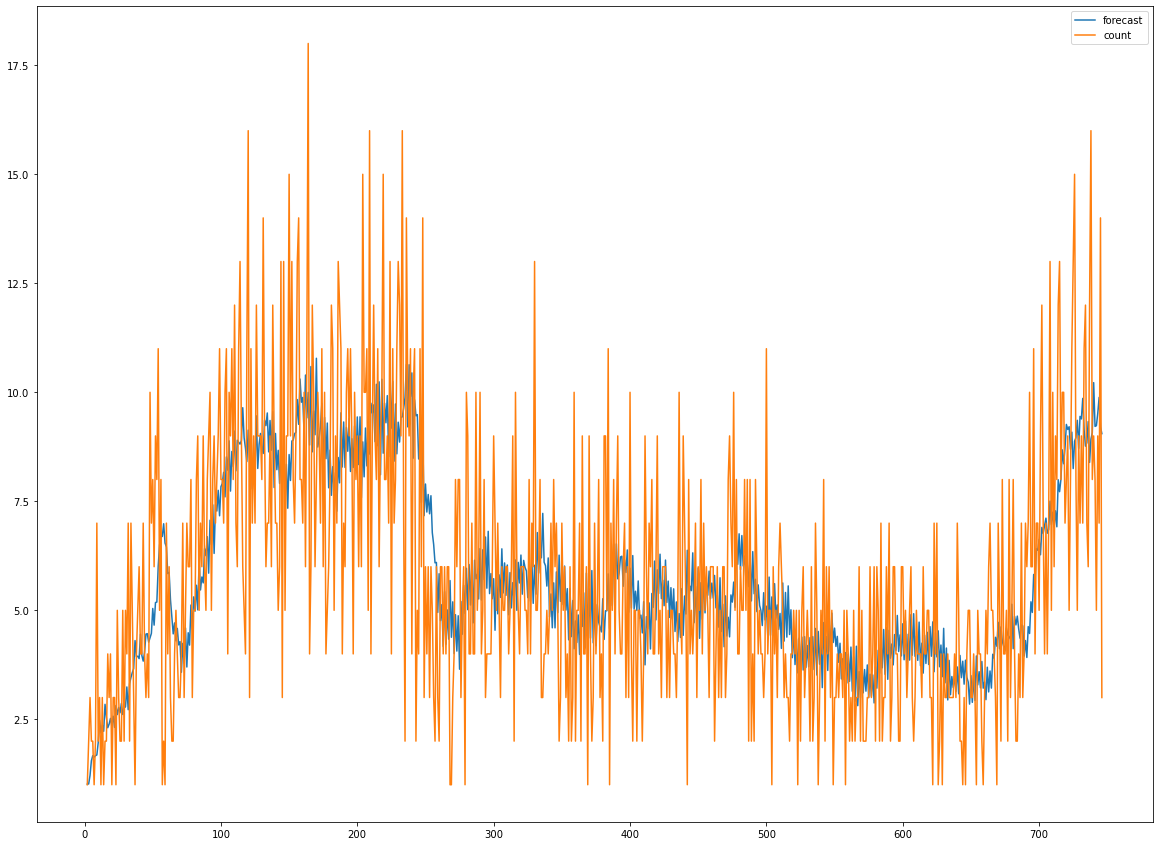

In [49]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [50]:
preds, _, _ = model_fit.forecast(16)
preds = preds.tolist()
preds = [int(item) for item in preds]
months = ['2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', 
          '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01']

new_df = pd.DataFrame()
new_df['month_year'] = months
new_df['count'] = preds
data = pd.concat([ds, new_df])

fig = px.line(
    data, 
    x="month_year", 
    y="count", 
    title='Launches per month prediction'
)

fig.show()

## Thanks for reading !!!